<a href="https://colab.research.google.com/github/linyuehzzz/5523_project/blob/main/sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Stochastic Gradient Descent for Logistic Regression**
This code implements and tests the SGD algorithm for logistic regression
in different scenarios.  
Yifei Zhang (zhang.5387 at osu edu), Yue Lin (lin.3326 at osu.edu)  
Created: 11/12/2020

#### **Set up libraries**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#### **Project**

##### Projection function for hypercube

In [ ]:
def cube_prj(sample):
    '''
    This function projects both domain and parameter sets to a hypercube.

    sample: features or gradients, 1*d array (d: #dimension)

    return: 
        a hypercube with edge length 2 and centered around the origin
    '''
    return [np.sign(i) * min(np.abs(i), 1) for i in sample]

##### Projection function for unit ball

In [ ]:
def ball_prj(sample):
    '''
    This function projects both domain and parameter sets to a unit ball.

    sample: features or gradients, 1*d array (d: #dimension)

    return: 
        a unit ball centered around the origin
    '''
    ratio = 1 / np.linalg.norm(sample)
    return [i * ratio for i in sample]

##### Project data

In [ ]:
def prj_data(x, y, prj_code):
    '''
    This function projects the domain set in terms for two scenarios.

    X: feature vectors, n*d array (n: #sample, d: #dimension)
    y: labels, 1*n array with values of -1 or +1
    prj_code: type of projection, 0 for cube, 1 for ball

    return:
        prj_x: projected feature vectors 
        y: labels, same as the input
    '''
    if prj_code == 0:
        prj_x = np.apply_along_axis(cube_prj, 1, x)
    elif prj_code == 1:
        prj_x = np.apply_along_axis(ball_prj, 1, x)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
      
    b = np.ones((prj_x.shape[0], 1))
    prj_x = np.append(prj_x, b, axis=1)
    return prj_x, y

##### Project gradient

In [ ]:
def prj_grad(g, prj_code):
    '''
    This function projects the parameter set for two scenarios.

    g: gradients, 1*d array (d: #dimension)
    prj_code: type of projection, 0 for cube, 1 for ball

    return:
        prj_g: projected gradients
    '''
    if prj_code == 0:
        prj_g = cube_prj(g)
    elif prj_code == 1:
        prj_g = ball_prj(g)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
    return prj_g

#### **Prepare data**

In [ ]:
def gen_data(sig, n, d_dimension):
    '''
    This function generates the data for training and test.

    sig: standard deviation of the Gaussian function
    n: number of samples
    d_dimension: dimensionality of the feature vectors
    
    Return:
        X: feature vectors, n*d array (n: #sample, d: #dimension)
        y: labels, 1*n array with values of -1 and +1
    '''
    # d_dimension = 4
    y = np.random.choice([-1, 1], p = [0.5, 0.5], size = n)
    x = np.array([])
    for i in range(n):
        if y[i] == -1:
            mu = -(1 / 4)
            negvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, negvec], axis=0)
        else:
            mu = (1 / 4)
            posvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, posvec], axis=0)
    x = np.reshape(x, (n, d_dimension))
    return x, y

#### **Train**
https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/

##### Predict using logistic regression

In [ ]:
def pred(X, w):
    '''
    This function makes binary classification using logistic regression.

    X: feature vector, 1*d array (d: #dimension)
    w: weight vector, 1*d array
    
    Return:
        yhat: predicted output
    '''
    yhat = 0.
    for i in range(X.shape[0]):
        yhat += w[i] * X[i]
    yhat = 1.0 / (1.0 + np.exp(-yhat))
    if yhat < 0.5:
        yhat = -1
    else:
        yhat = 1 
    return yhat

##### Estimate logistic loss

In [ ]:
def log_loss(X, y, w):
    '''
    This function outputs the logistic loss.

    X: feature vectors, n*d array (n: #sample, d: #dimension)
    y: labels, 1*n array
    w: weight vectors, n*d array
    
    Return: logistic loss
    '''
    return np.log(1 + np.exp(-y * np.dot(w.T, X)))

##### Estimate classification error

In [ ]:
def err(yhat, y):
    '''
    This function outputs the classification error.

    yhat: predicted label
    y: label
    
    Return: classification error
    '''
    if yhat == y:
        return 0
    else:
        return 1

##### SGD

In [ ]:
def sgd(X, y, w_t, prj_code, l_rate):
    '''
    This function implements SGD.

    X: feature vectors, n*d array (n: #sample, d: #dimension)
    y: labels, 1*n array
    w_t: weights at t, n*d array
    prj_code: type of projection, 0 for cube, 1 for ball
    l_rate: learning rate
    
    Return: 
        w_t: updated weight at t+1
    '''
    w_t = np.array(w_t)
    # Calculate gradient
    g = (-y * X * np.exp(-y * np.dot(w_t.T, X)) / (1 + np.exp(-y * np.dot(w_t.T, X))))
    # Project gradient
    w_t = prj_grad(np.add(w_t, np.multiply(-l_rate, g)), prj_code)
    return w_t

##### Estimate weight vector using SGD

In [ ]:
def train(train_x, train_y, test_x, test_y, l_rate, n_epoch, bs, prj_code):
    '''
    This function implements and tests the SGD algorithm for logistic regression.

    train_x: feature vectors for training, n*d array (n: #sample, d: #dimension)
    train_y: labels for training, 1*n array
    test_x: feature vectors for test, n*d array (n: #sample, d: #dimension)
    test_y: labels for test, 1*n array
    l_rate: learning rate
    n_epoch: number of trials
    bs: training set size
    prj_code: type of projection, 0 for cube, 1 for ball
    
    Return: 
        w: final weights
        risk_ave: average risk
        risk_min: minimum of all risks
        risk_var: standard deviation of all risks
        exp_excess_risk: expected excess risk
        cls_err_ave: average classification error
        cls_err_var: standard deviation of all classification errors
    '''
    risk_all = []
    cls_err_all = []

    for epoch in range(n_epoch):
        w_t = np.random.uniform(-1, 1, (train_x.shape[1]))
        risk = cls_err = 0.
        w_all = []
        for idx in range(epoch * bs, (epoch + 1) * bs):
            # Read data
            X = train_x[idx]
            y = train_y[idx]
            # SGD
            w_t = sgd(X, y, w_t, prj_code, l_rate)
            # Backward propagation
            w_all.append(w_t)
    
        w = np.average(np.array(w_all), axis=0)
        # print(w_all, w)
    
        # Evaluate
        for idx in range(test_x.shape[0]):
            # Read data
            X = test_x[idx]
            y = test_y[idx]
            # Predict
            yhat = pred(X, w)
            # Evaluate
            risk += log_loss(X, y, w) / test_x.shape[0]
            cls_err += err(yhat, y) / test_x.shape[0]
    
        risk_all = np.append(risk_all, risk)
        cls_err_all = np.append(cls_err_all, cls_err)
        # print('>epoch=%d, lrate=%.3f, risk=%.3f, classification error=%.3f' % (epoch, l_rate, risk, cls_err))
  
    # Report risk
    # print(risk_all, cls_err_all)
    risk_ave = np.average(risk_all)
    risk_min = np.amin(risk_all)
    risk_var = np.sqrt(np.var(risk_all))
    exp_excess_risk = risk_ave - risk_min
    # Report classification error
    cls_err_ave = np.average(cls_err_all)
    cls_err_var = np.sqrt(np.var(cls_err_all))
    return [w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#### **Wrapper test**

##### Generate data and train

In [ ]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 0    # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.16  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution
d_dimension = 4

np.random.seed(1)

excess_risk = []
cls_error = []
excess_risk_var = []
cls_error_var = []

for bs in train_bs:
    # Generate training data
    train_x, train_y = gen_data(sigma, bs * n_epoch, d_dimension)
    train_px, train_py = prj_data(train_x, train_y, prj_code)

    # Generate test data
    test_x, test_y = gen_data(sigma, test_n, d_dimension)
    test_px, test_py = prj_data(test_x, test_y, prj_code)

    # Train
    output = train(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
    print(output)
    print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
            excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
            % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
    
    excess_risk = np.append(excess_risk, output[4], axis=None)
    cls_error = np.append(cls_error, output[5],  axis=None)
    excess_risk_var = np.append(excess_risk_var, output[3], axis=None)
    cls_error_var = np.append(cls_error_var, output[6],  axis=None)

[array([-0.18897699,  0.05354815,  0.34840153, -0.07563363, -0.04980467]), 0.5208856714013164, 0.37094769357192814, 0.08603300863131619, 0.14993797782938822, 0.14925000000000008, 0.16691833082878196]
>scenario=1, sigma=0.10, n=50, log_loss_mean=0.521, log_loss_std_dev=0.086, log_loss_min=0.371,             excess_risk=0.150, cls_error_mean=0.149, cls_error_std_dev=0.167
[array([ 0.9814903 ,  0.94495039,  0.32290242, -0.04594593, -0.11793739]), 0.4530631058684069, 0.3372746650374369, 0.04633832285216711, 0.11578844083097001, 0.00325, 0.007307245262979293]
>scenario=1, sigma=0.10, n=100, log_loss_mean=0.453, log_loss_std_dev=0.046, log_loss_min=0.337,             excess_risk=0.116, cls_error_mean=0.003, cls_error_std_dev=0.007
[array([0.92026751, 0.99258903, 0.86635786, 0.78921267, 0.10112228]), 0.3445910000876896, 0.33173363062021854, 0.007622486945538221, 0.01285736946747107, 0.0, 0.0]
>scenario=1, sigma=0.10, n=500, log_loss_mean=0.345, log_loss_std_dev=0.008, log_loss_min=0.332,     

##### Plot excess risk

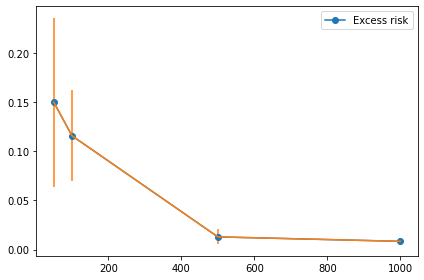

In [ ]:
plt.plot(train_bs, excess_risk, '-o', label='Excess risk')
plt.errorbar(train_bs, excess_risk, excess_risk_var)
plt.legend()
plt.tight_layout()
plt.show()

##### Plot classification error

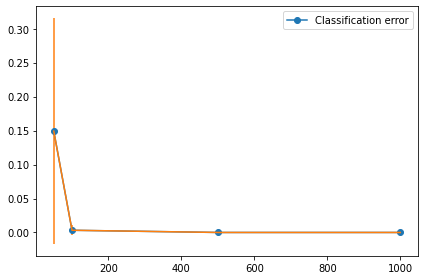

In [ ]:
plt.plot(train_bs, cls_error, '-o', label='Classification error')
plt.errorbar(train_bs, cls_error, cls_error_var)
plt.legend()
plt.tight_layout()
plt.show()

#### **Wrapper**

In [ ]:
# Set up hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set
d_dimension = 4
train_bs = np.array([50, 100, 500, 1000])  # batch size for each training epoch

np.random.seed(1)

##### Run all experiments

In [ ]:
result_list = []
for prj_code in [0, 1]:
    for sigma in [0.1, 0.35]:
        for bs in train_bs:

            if prj_code == 0:
                m = 2 * np.sqrt(d_dimension + 1)
            else:
                m = 2

            rho = d_dimension + 1
            l_rate = m / (rho * np.sqrt(bs))

            # Generate training data
            train_x, train_y = gen_data(sigma, bs * n_epoch, d_dimension)
            train_px, train_py = prj_data(train_x, train_y, prj_code)

            # Generate test data
            test_x, test_y = gen_data(sigma, test_n, d_dimension)
            test_px, test_py = prj_data(test_x, test_y, prj_code)

            # Train
            output = train(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
            #[w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

            print(output)
            print('>scenario=%d, sigma=%.2f, n=%d, lr=%.2f, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
                excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
                % (prj_code+1, sigma, bs, l_rate, output[1], output[3], output[2], output[4], output[5], output[6]))
            result = [prj_code + 1, sigma, bs, n_epoch,output[1], output[3], output[2], output[4], output[5], output[6]]
            result_list.append(result)

[array([-0.30213708, -0.04556574,  0.24957251, -0.18296978,  0.00961437]), 0.5493448990903909, 0.38202462039170165, 0.0961496852184802, 0.1673202786986892, 0.2364999999999998, 0.23441647410822677]
>scenario=1, sigma=0.10, n=50, lr=0.13, log_loss_mean=0.549, log_loss_std_dev=0.096, log_loss_min=0.382,                 excess_risk=0.167, cls_error_mean=0.236, cls_error_std_dev=0.234
[array([ 0.96393855,  0.91094144, -0.0239014 , -0.38505455, -0.21325635]), 0.5366265668640656, 0.35834690538255304, 0.07715830587575896, 0.17827966148151259, 0.11825000000000009, 0.14850946939505252]
>scenario=1, sigma=0.10, n=100, lr=0.09, log_loss_mean=0.537, log_loss_std_dev=0.077, log_loss_min=0.358,                 excess_risk=0.178, cls_error_mean=0.118, cls_error_std_dev=0.149
[array([ 0.67194848,  0.97265623,  0.45761492,  0.15884505, -0.04393008]), 0.4212756006212695, 0.36536653995281837, 0.03533393194251, 0.05590906066845114, 0.001333333333333333, 0.004687453703475077]
>scenario=1, sigma=0.10, n=500,

##### Plot table

In [ ]:
column_name = ["Scenario", "sigma", "N", "#trails", "Loss_Mean", "Loss_StdDev", "Loss_Min", "Loss_ExcessRisk",
             "Error_Mean", "Error_StdDev"]
result_df = pd.DataFrame(result_list, columns = column_name)
result_df

,Scenario,sigma,N,#trails,Loss_Mean,Loss_StdDev,Loss_Min,Loss_ExcessRisk,Error_Mean,Error_StdDev
0,1,0.10,50,30,0.549345,0.096150,0.382025,0.167320,0.236500,0.234416
1,1,0.10,100,30,0.536627,0.077158,0.358347,0.178280,0.118250,0.148509
2,1,0.10,500,30,0.421276,0.035334,0.365367,0.055909,0.001333,0.004687
3,1,0.10,1000,30,0.390512,0.020247,0.337979,0.052533,0.000000,0.000000
4,1,0.35,50,30,0.562977,0.075219,0.433738,0.129238,0.276667,0.102299
5,1,0.35,100,30,0.537027,0.085720,0.387975,0.149053,0.225333,0.131237
6,1,0.35,500,30,0.441465,0.030804,0.386903,0.054563,0.111833,0.019663
7,1,0.35,1000,30,0.418091,0.023252,0.375485,0.042606,0.084333,0.012599
8,2,0.10,50,30,0.534730,0.130990,0.341652,0.193078,0.226250,0.253846
9,2,0.10,100,30,0.518017,0.153447,0.336479,0.181538,0.160750,0.234262


##### Plot grid

In [ ]:
def plot_result(estimator, result_df):
    '''
    estimator: 
        0 is for ["Loss_ExcessRisk", "Loss_StdDev"]
        1 is for ["Error_Mean", "Error_StdDev"]
    result_df:
        result table above
    
    '''
    if estimator == 0:
        col = ["Loss_ExcessRisk", "Loss_StdDev"]
    else:
        col = ["Error_Mean", "Error_StdDev"]
        
    fig = plt.figure(figsize = (16, 10))
    index = 0
    for senario in [1, 2]:
        for sigma in [0.1, 0.35]:
            index += 1
            plt.subplot(2, 2, index)
            df = result_df[np.logical_and(result_df["Scenario"] == senario, result_df["sigma"] == sigma)]
            excess_risk, excess_risk_var = df[col[0]], df[col[1]]

            plt.plot(train_bs, excess_risk, '-o', label = col[0])
            plt.errorbar(train_bs, excess_risk, excess_risk_var)

            plt.xlabel("N", fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.ylabel("Risk", fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.title("Scenario " + str(senario) + ", Sigma=" + str(sigma), fontsize=15) 
    fig.legend(col, loc = "upper right", fontsize = 13)
    plt.tight_layout()
    plt.show()

###### Plot excess risk

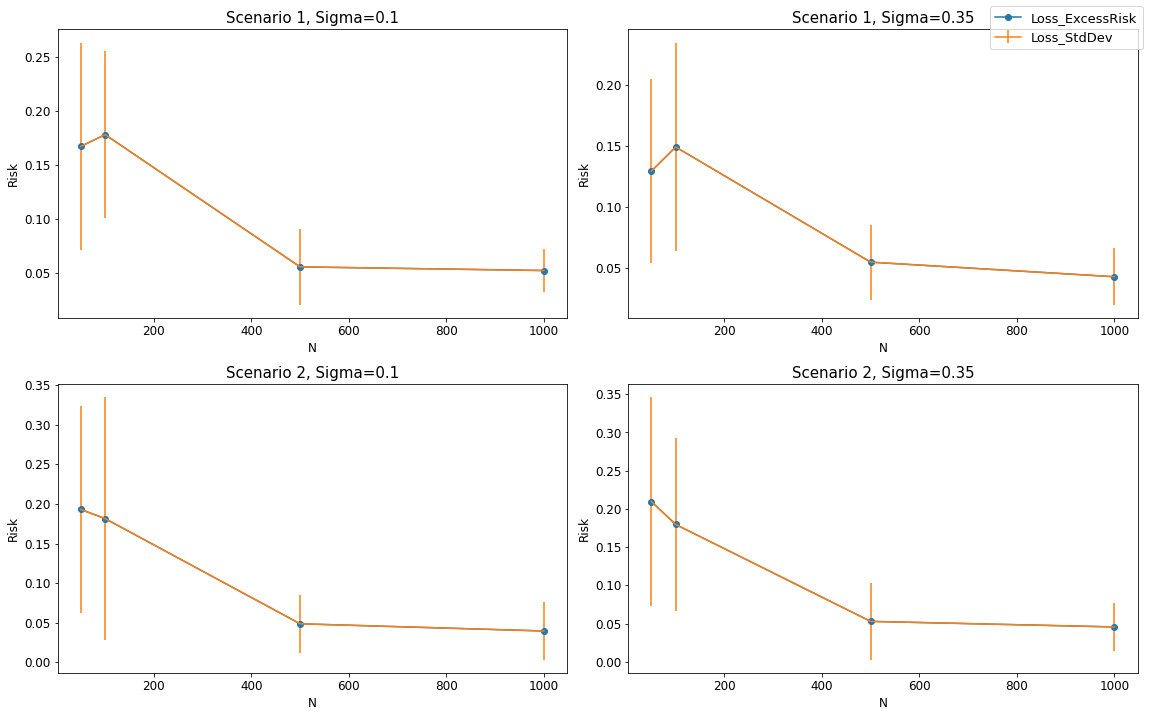

In [ ]:
plot_result(0, result_df)

###### Plot classification error

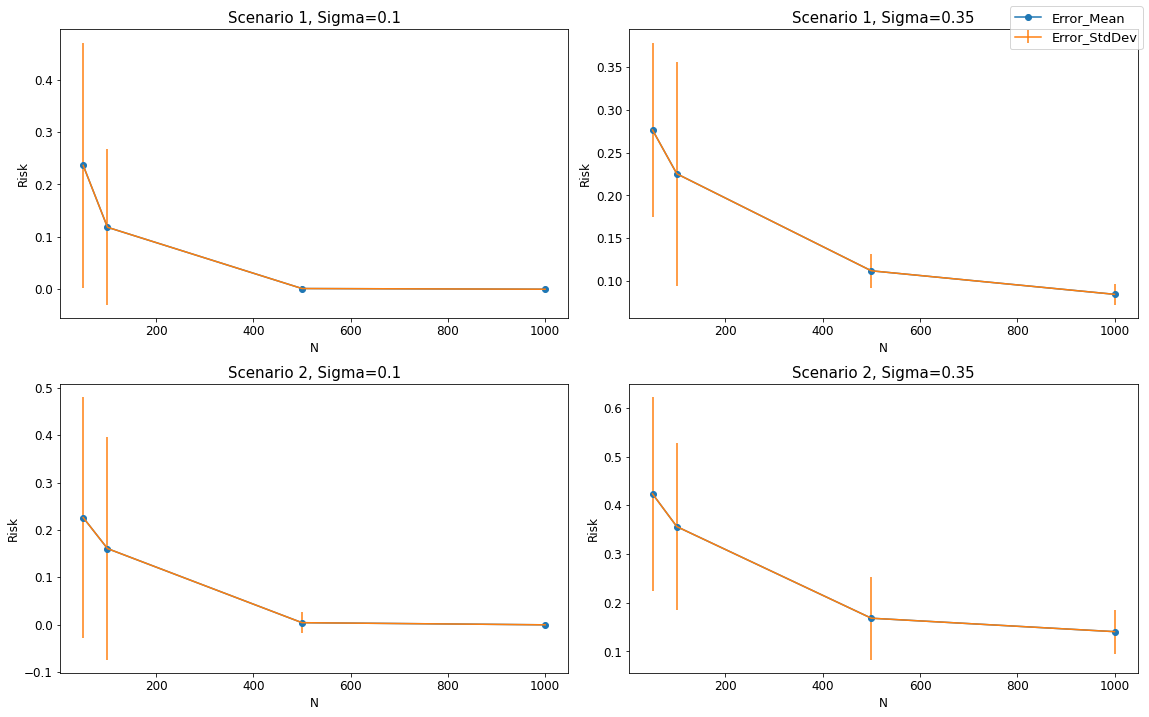

In [ ]:
plot_result(1, result_df)